In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# Tests to see can fix the OOM problems
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.50'
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union, Type, List
import numpy as np
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# # PyTorch for Dataloaders
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms

# JAX/Flax
import jax
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state, orbax_utils
import optax
import orbax
import wandb
from tqdm import tqdm

from visualization import visualize as vis
from data import data_functions as df
from models import train_model as trm
from models import generate_model as gen

In [2]:
class JaxDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, segmentation = self.dataset[idx]
        # Convert data to numpy arrays
        image = np.array(image)
        segmentation = np.array(segmentation)
        return image, segmentation

In [3]:
# Download the dataset with images & segmentations (as labels)
# resize the images & segmentations to be 224x224
train_set = OxfordIIITPet(root='/home/mdowicz/PFGMPP/data/raw',
                          split='trainval',
                          target_types='segmentation',
                          download=True,
                          transform=transforms.Resize((128, 128)),                   
                          target_transform=transforms.Resize((128, 128)))

# Convert downloaded data to jax compatible datasets/dataloaders
train_set = JaxDataset(dataset=train_set)
train_loader = df.NumpyLoader(dataset=train_set,
                              batch_size=2,
                              shuffle=True)
batch = next(iter(train_loader))

test_set = OxfordIIITPet(root='/home/mdowicz/PFGMPP/data/raw',
                         split='test',
                         target_types='segmentation',
                         download=True,
                         transform=transforms.Resize((128, 128)),
                         target_transform=transforms.Resize((128, 128)))

test_set = JaxDataset(dataset=test_set)
# test_loader = df.NumpyLoader(dataset=test_set, batch_size=64, shuffle=True)

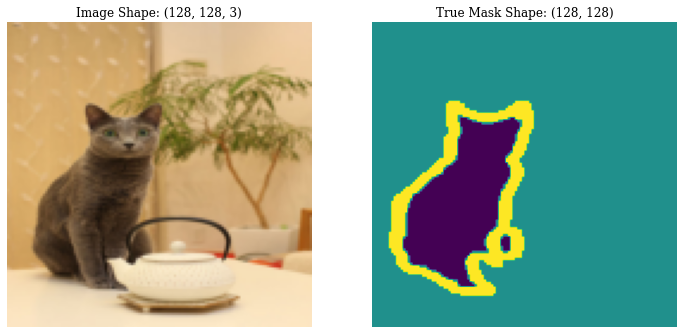

In [4]:
def visualize_sample(batch, idx):
    image, segmentation = batch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(image[idx])
    ax1.set_title(f"Image Shape: {image[idx].shape}")
    ax1.axis("off")
    
    ax2.imshow(segmentation[idx])
    ax2.set_title(f"True Mask Shape: {segmentation[idx].shape}")
    ax2.axis("off")
    
    plt.show()

visualize_sample(batch, 1)

In [5]:
class DoubleConvolution(nn.Module):
    filters: int
    kernel_size: int = (3, 3)
    strides: int = (1, 1)
    padding: int = "SAME"

    def setup(self):
        self.conv1 = nn.Conv(self.filters, self.kernel_size,
                             self.strides, padding=self.padding)
        self.act1 = nn.relu

        self.conv2 = nn.Conv(self.filters, self.kernel_size,
                             self.strides, padding=self.padding)
        self.act2 = nn.relu

    def __call__(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        return x

class DownSample(nn.Module):
    window_shape: int = (2, 2)
    strides: int = (2, 2)
    padding: str = "VALID"

    def __call__(self, x):
        return nn.max_pool(x, window_shape=self.window_shape,
                           strides=self.strides, padding=self.padding)

class UpSample(nn.Module):
    filters: int
    kernel_size: int = (2, 2)
    strides: int = (2, 2)
    padding: Any = (1, 1)

    def setup(self):
        self.up_conv = nn.ConvTranspose(self.filters,
                                       self.kernel_size,
                                       strides=self.strides,
                                       padding=self.padding)

    def __call__(self, x):
        return self.up_conv(x)

class UNet(nn.Module):
    depth: int = 4
    initial_filters: int = 64
    output_channels: int = 3

    def setup(self):
        # Encoder
        self.down_blocks = [DoubleConvolution(self.initial_filters * 2**i) for i in range(self.depth)]
        self.downsamples = [DownSample() for _ in range(self.depth)]
        
        # Bottleneck 
        self.bottleneck_block = DoubleConvolution(self.initial_filters * 2**self.depth)

        # Decoder
        self.up_samples = [UpSample(self.initial_filters * 2**(i-1)) for i in range(self.depth, 0, -1)]
        self.up_blocks = [DoubleConvolution(self.initial_filters * 2**i) for i in range(self.depth-1, -1, -1)]

        # Final Convolutional Layer
        self.final_conv = nn.Conv(self.output_channels, 
                                  kernel_size=(1, 1),
                                  strides=(1, 1),
                                  padding="SAME")

    def __call__(self, x):
        skip_connections = []
        
        # Encoder path
        for i in range(self.depth):
            x = self.down_blocks[i](x)
            skip_connections.append(x)
            x = self.downsamples[i](x)
            # print(f'Encoder{i+1} x.shape =', x.shape)

        # Bottleneck
        x = self.bottleneck_block(x)
        # print('Bottleneck x.shape =', x.shape)

        # Decoder path
        for i in range(self.depth):
            x = self.up_samples[i](x)
            x = jnp.concatenate([x, skip_connections.pop()], axis=-1)
            # print(f'Skip_connection{i+1} x.shape =', x.shape)
            x = self.up_blocks[i](x)
            # print(f'Decoder{i+1} x.shape =', x.shape)

        # Final Convolution layer
        x = self.final_conv(x)
        # print('Final x.shape =', x.shape)

        return x

# model = UNet(depth=4 ,initial_filters=128, output_channels=3)
# rng = random.PRNGKey(2)
# print(model.tabulate(rng, jnp.ones((1, 128, 128, 3))))
# print()

# 3. Training Loop

In [6]:
def init_train_state(model: Any,
                     random_key: Any,
                     x_shape: tuple,
                     learning_rate: int) -> train_state.TrainState:
    """
    Function to initialize the TrainState dataclass, whcih represents
    the entire training state, including step number, parameteers, and 
    optimizer state. Used in a Flax framework because you no longer need
    to initialize the model again & again with new variables. Rather we 
    just update the "state" of the model and pass this as inputs to functions.
    
    Args:
    -----
        model: nn.Module
            Model we want to train.
        random_key: jax.random.PRNGKey()
            Used to trigger the initialization functions, which generate
            the initial set of parameters that the model will use.
        x_shape: tuple
            Shape of the batch of data (x) that will be input into the model.
            Used to trigger shape inference.

        learning_rate: float
            How large of a step the optimizer should take.
            
    Returns:
    --------
        train_state.TrainState:
            A utility class for handling parameter and gradient updates.
    """
    # Initialize the model
    variables = model.init(random_key, jnp.ones(x_shape))
    
    # Create the optimizer
    optimizer = optax.adam(learning_rate)
    
    # Create a state
    return flax.training.train_state.TrainState.create(apply_fn=model.apply,
                                                       tx=optimizer,
                                                       params=variables['params'])

In [7]:
def train_step(state: train_state.TrainState, batch: jnp.ndarray):
    """
    """
    image, segmentation = batch
    segmentation_shifted = segmentation - 1 # makes it 0 indexed (0,1,2) instead of (1,2,3)
    # Define the loss function
    def loss_fn(params):
        pred = state.apply_fn({'params': params}, image)
        loss = optax.softmax_cross_entropy_with_integer_labels(pred, segmentation_shifted).mean()
        return loss
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(state.params)
    new_state = state.apply_gradients(grads=grad)
    return new_state, loss

def eval_step(state, batch):
    image, segmentation = batch
    segmentation_shifted = segmentation - 1
    pred = state.apply_fn({'params': state.params}, image)
    return optax.softmax_cross_entropy_with_integer_labels(pred, segmentation_shifted).mean()

def accumulate_metrics(metrics):
    """
    Function that accumulates all the per batch metrics into
    per epoch metrics
    """
    metrics = jax.device_get(metrics)
    return {
        k: np.mean([metric[k] for metric in metrics])
        for k in metrics[0]
    }

def save_checkpoint(ckpt_dir: str,
                    state: Any,
                    step: int,
                    wandb_logging: bool = False) -> None:
    """
    Save the training state as a checkpoint

    Args:
    -----
        ckpt_dir: str
            Directory to save the checkpoint files.
        state: Any
            The training state to be saved.
        step: int
            Current training step or epoch number.
        wandb_logging: bool
            If True, uses the wandb run name in the checkpoint filename.
            Default is False.
    """
    ckptr = orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler())

    # Ensure directory exists
    os.makedirs(ckpt_dir, exist_ok=True)

    # Get the wandb run name or id if wandb logging is enabled
    run_name = wandb.run.name if wandb_logging else ""

    # Create checkpoint file path with the ".flax" extension and the wandb run name if applicable
    ckpt_file = os.path.join(ckpt_dir, f"checkpoint_{run_name}_{step}epochs.flax")

    # Save checkpoint to local directory
    ckptr.save(ckpt_file, state,
               save_args=flax.training.orbax_utils.save_args_from_target(state),
               force=True)

    # If wandb logging is enabled, save the checkpoint to wandb run
    if wandb_logging:
        wandb.save(ckpt_file)

    

def train_model(train_loader, test_loader, model, state, config, wandb_logging=False, project_name='toy_UNET', dir_name='PFGMPP/saved_models/UNET_toy'):
    """
    Train a machine learning model with optional Weights & Biases (wandb) logging.

    Parameters:
    -----------
    train_loader: 
        A data loader providing the training data.
    model: 
        The model to be trained.
    state: 
        The initial state of the model.
    config: dict
        A dictionary containing configuration parameters for training, such as learning rate, batch size etc.
    wandb_logging: bool
        If True, training progress is logged using wandb.
        Default is False.
    project_name: str
        The name of the wandb project. Only used if wandb_logging is True.
        Default is 'toy_pfgmpp'.
    job_type: str
        The type of job for wandb logging. Only used if wandb_logging is True.
        Default is 'simple_noise_net'.
    dir_name: str
        The directory where the model checkpoints will be saved. Also used for wandb logging if wandb_logging is True. Default is 'saved_models/toy'.

    Returns:
    --------
        model: The trained model.
        state: The final state of the model after training.
    """
    # Get the absolute path of the saved_models/toy directory
    dir_name = os.path.join(os.path.expanduser('~'), str(dir_name))
    # If wandb logging is enabled, initialize wandb
    if wandb_logging:
        wandb.init(project=project_name, job_type=job_type, dir= dir_name)
        wandb.config.update(config)

    # Start the training loop
    for epoch in tqdm(range(config['epochs'])):
        # Initialize a list to store all batch-level metrics
        batch_metrics = []
        test_batch_metrics = []

        for batch in train_loader:
            # Prepare the data
            # batch = jax.device_put(batch)

            # Update the model
            train_step_jit = jax.jit(train_step)
            state, batch_loss = train_step_jit(state, batch) 

            # Store the batch-level metric in the list
            batch_metrics.append({'Train Loss': batch_loss})

        # Get the test loss during training
        for batch in test_loader:
            eval_step_jit = jax.jit(eval_step)
            test_batch_loss = eval_step_jit(state, batch)
            test_batch_metrics.append({'Test Loss': test_batch_loss})
            
        # Use accumulate_metrics to calculate average metrics for the epoch
        train_epoch_metrics = accumulate_metrics(batch_metrics)
        print('Train Epoch Loss =', train_epoch_metrics)
        test_epoch_metrics = accumulate_metrics(test_batch_metrics)
        print('Test Epoch Loss =', test_epoch_metrics)

        # If wandb logging is enabled, log metrics
        if wandb_logging:
            wandb.log(train_epoch_metrics)
            wandb.log(test_epoch_metrics)
        
    # Save checkpoint
    checkpt_dir = dir_name # dir to save the checkpoints
    save_checkpoint(checkpt_dir, state, config['epochs'], project_name)

    return model, state

In [8]:
config = {
    'seed': 47,
    'batch_size': 64,
    'learning_rate': 1e-4,
    'epochs': 2,
    'depth': 5,
    'initial_filters': 64,
    'output_channels': 3
}

train_loader = df.NumpyLoader(dataset=train_set,
                              batch_size=config['batch_size'],
                              shuffle=True)
train_batch = next(iter(train_loader))

test_loader = df.NumpyLoader(dataset=test_set,
                             batch_size=config['batch_size'],
                             shuffle=False)

# Get the rng & model instantiated
init_rng = random.PRNGKey(config['seed'])
model = UNet(depth=config['depth'],
             initial_filters=config['initial_filters'],
             output_channels=config['output_channels'])
print('Model instantiated')

# Initialize the models state
state = init_train_state(model=model,
                         random_key=init_rng,
                         x_shape=train_batch[0].shape,
                         learning_rate=config['learning_rate'])
print('Model initiliazed')

# Call the training function
model, state = train_model(train_loader,
                           test_loader,
                           model,
                           state,
                           config,
                           wandb_logging=True,
                           project_name='toy_UNET',
                           job_type='UNET_implementation',
                           dir_name='PFGMPP/saved_models/UNET_toy')

Model instantiated


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model initiliazed


wandb: Currently logged in as: mdowicz. Use `wandb login --relogin` to force relogin


 50%|█████     | 1/2 [01:30<01:30, 90.43s/it]

Train Epoch Loss = {'Train Loss': 1.5731248}
Test Epoch Loss = {'Test Loss': 0.96226513}


100%|██████████| 2/2 [02:02<00:00, 61.02s/it]

Train Epoch Loss = {'Train Loss': 0.82968336}
Test Epoch Loss = {'Test Loss': 0.8129851}



wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


# Scratch Work

`setattr()` is used to dynamically create each `down_block`, `downsample_block`, `up_sample`, and `up_block` within the loop. Then `getattr()` is used to call these blocks when needed. The index i in the loop ranges from `0 to depth - 1`, so we use `i+1` to match your original block numbering that starts from `1`.

In [9]:
# class DoubleConvolution(nn.Module):
#     filters: int
#     kernel_size: int = (3, 3)
#     strides: int = (1, 1)
#     padding: int = "SAME"

#     def setup(self):
#         self.conv1 = nn.Conv(self.filters, self.kernel_size,
#                              self.strides, padding=self.padding)
#         self.act1 = nn.relu

#         self.conv2 = nn.Conv(self.filters, self.kernel_size,
#                              self.strides, padding=self.padding)
#         self.act2 = nn.relu

#     def __call__(self, x):
#         x = self.conv1(x)
#         x = self.act1(x)
#         x = self.conv2(x)
#         x = self.act2(x)
#         return x

# class DownSample(nn.Module):
#     window_shape: int = (2, 2)
#     strides: int = (2, 2)
#     padding: str = "VALID"

#     def __call__(self, x):
#         return nn.max_pool(x, window_shape=self.window_shape,
#                            strides=self.strides, padding=self.padding)

# class UpSample(nn.Module):
#     filters: int
#     kernel_size: int = (2, 2)
#     strides: int = (2, 2)
#     padding: int = (1, 1)

#     def setup(self):
#         self.up_conv = nn.ConvTranspose(self.filters,
#                                        self.kernel_size,
#                                        strides=self.strides,
#                                        padding=self.padding)

#     def __call__(self, x):
#         return self.up_conv(x)
        
# class UNet(nn.Module):
#     depth: int = 4
#     initial_filters: int = 64
#     output_channels: int = 1

#     def setup(self):
#         # Encoder & Downsample Blocks
#         for i in range(self.depth):
#             setattr(self, f'down_block{i+1}', DoubleConvolution(self.initial_filters * (2 ** i)))
#             setattr(self, f'downsample_block{i+1}', DownSample())

#         # Bottleneck Block
#         self.bottleneck_block = DoubleConvolution(self.initial_filters * (2 ** self.depth))

#         # Upsample & Decoder Blocks
#         for i in reversed(range(self.depth)):
#             setattr(self, f'up_sample{i+1}', UpSample(self.initial_filters * (2 ** i)))
#             setattr(self, f'up_block{i+1}', DoubleConvolution(self.initial_filters * (2 ** i)))

#         # Final Convolutional Layer
#         self.final_conv = nn.Conv(self.output_channels, 
#                                   kernel_size=(1, 1),
#                                   strides=(1, 1),
#                                   padding="SAME")
    
#     def __call__(self, x):
#         skip_connections = []

#         # Encoder path
#         for i in range(self.depth):
#             x = getattr(self, f'down_block{i+1}')(x)
#             skip_connections.append(x)
#             x = getattr(self, f'downsample_block{i+1}')(x)

#         # Bottleneck
#         x = self.bottleneck_block(x)

#         # Decoder path
#         for i in reversed(range(self.depth)):
#             x = getattr(self, f'up_sample{i+1}')(x)
#             x = jnp.concatenate([x, skip_connections.pop()], axis=-1)
#             x = getattr(self, f'up_block{i+1}')(x)

#         # Final Convolution layer
#         x = self.final_conv(x)

#         return x

# model = UNet(depth=5, initial_filters=64, output_channels=3)
# rng = random.PRNGKey(2)
# print(model.tabulate(jax.random.PRNGKey(9), batch[0]))

In [10]:
# class UNet(nn.Module):
#     depth: int = 4
#     initial_filters: int = 64
#     output_channels: int = 3

#     def setup(self):
#         # Encoder 
#         self.down_block1 = DoubleConvolution(self.initial_filters)
#         self.down_block2 = DoubleConvolution(self.initial_filters*2)
#         self.down_block3 = DoubleConvolution(self.initial_filters*4)
#         self.down_block4 = DoubleConvolution(self.initial_filters*8)

#         self.downsample_block1 = DownSample()
#         self.downsample_block2 = DownSample()
#         self.downsample_block3 = DownSample()
#         self.downsample_block4 = DownSample()

        
#         # Bottleneck 
#         self.bottleneck_block = DoubleConvolution(self.initial_filters * 16)

#         # Decoder
#         self.up_sample4 = UpSample(self.initial_filters * 8)
#         self.up_sample3 = UpSample(self.initial_filters * 4)
#         self.up_sample2 = UpSample(self.initial_filters * 2)
#         self.up_sample1 = UpSample(self.initial_filters)
        
#         self.up_block4 = DoubleConvolution(self.initial_filters * 8)
#         self.up_block3 = DoubleConvolution(self.initial_filters * 4)
#         self.up_block2 = DoubleConvolution(self.initial_filters * 2)
#         self.up_block1 = DoubleConvolution(self.initial_filters)

#         # Final Convolutional Layer
#         self.final_conv = nn.Conv(self.output_channels, 
#                                   kernel_size=(1, 1),
#                                   strides=(1, 1),
#                                   padding="SAME")
#     def __call__(self, x):
#         skip_connections = []
        
#         # Encoder path
#         x = self.down_block1(x)
#         skip_connections.append(x)
#         x = self.downsample_block1(x)
#         print('Encoder1 x.shape =', x.shape)

#         x = self.down_block2(x)
#         skip_connections.append(x)
#         x = self.downsample_block2(x)
#         print('Encoder1 x.shape =', x.shape)


#         x = self.down_block3(x)
#         skip_connections.append(x)
#         x = self.downsample_block3(x)
#         print('Encoder1 x.shape =', x.shape)

#         x = self.down_block4(x)
#         skip_connections.append(x)
#         x = self.downsample_block4(x)
#         print('Encoder1 x.shape =', x.shape)

#         # Bottleneck
#         x = self.bottleneck_block(x)
#         print('Bottleneck x.shape =', x.shape)

#         # Decoder path
#         x = self.up_sample4(x)
#         x = jnp.concatenate([x, skip_connections.pop()], axis=-1)
#         print('Skip_connection1 x.shape =', x.shape)
#         x = self.up_block4(x)
#         print('Decoder4 x.shape =', x.shape)

#         x = self.up_sample3(x)
#         x = jnp.concatenate([x, skip_connections.pop()], axis=-1)
#         print('Skip_connection3 x.shape =', x.shape)
#         x = self.up_block3(x)
#         print('Decoder3 x.shape =', x.shape)

#         x = self.up_sample2(x)
#         x = jnp.concatenate([x, skip_connections.pop()], axis=-1)
#         print('Skip_connection2 x.shape =', x.shape)
#         x = self.up_block2(x)
#         print('Decoder2 x.shape =', x.shape)

#         x = self.up_sample1(x)
#         x = jnp.concatenate([x, skip_connections.pop()], axis=-1)
#         print('Skip_connection1 x.shape =', x.shape)
#         x = self.up_block1(x)
#         print('Decoder1 x.shape =', x.shape)

#         # Final Convolution layer
#         x = self.final_conv(x)
#         print('Final x.shape =', x.shape)

#         return x 